In this notebook we run jaxns on the simplified 5D gravitational wave problem

In [1]:
import sys
sys.path.append("..")

from models.taylorf2 import taylorf2
from models.taylorf2_spin import taylorf2 as taylorf2_spin
import jax.numpy as jnp
from jax import grad, config
import jax
import matplotlib.pyplot as plt
import os 
import numpy as np
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)
import corner

In [ ]:
jax.devices()

# Instantiate model class

In [ ]:
injection = jnp.array([0, 0, 30.0, 0.24, 0.05]) 

# Define prior ranges
priorDict = {}
priorDict[0] = injection[0] + jnp.array([-0.001, 0.001])
priorDict[1] = jnp.array([-jnp.pi, jnp.pi])
priorDict[2] = jnp.array([27.5, 32.5])
priorDict[3] = jnp.array([0.2, 0.249])
priorDict[4] = jnp.array([0.02, 0.07])

# Instantiate model
model = taylorf2(injection, priorDict)

In [2]:
### Spinning ###

injection = jnp.array([0, 0, 1.2, 0.245, 0.05, 0.1, 0.2]) 

priorDict = {}
priorDict[0] = injection[0] + jnp.array([-0.001, 0.001])
priorDict[1] = jnp.array([-jnp.pi, jnp.pi])
priorDict[2] = jnp.array([1.19, 1.21]) 
priorDict[3] = jnp.array([0.2, 0.249])
priorDict[4] = jnp.array([0.02, 0.07])
priorDict[5] = jnp.array([0, 0.2]) 
priorDict[6] = jnp.array([0.1, 0.3])

model = taylorf2_spin(injection, priorDict)
print('n_bins=%i' % model.n_bins)

SNR is: 17.09462262749192
n_bins=1000


# What does the strain look like?

Text(0.5, 1.0, 'Gravitational wave strain data')

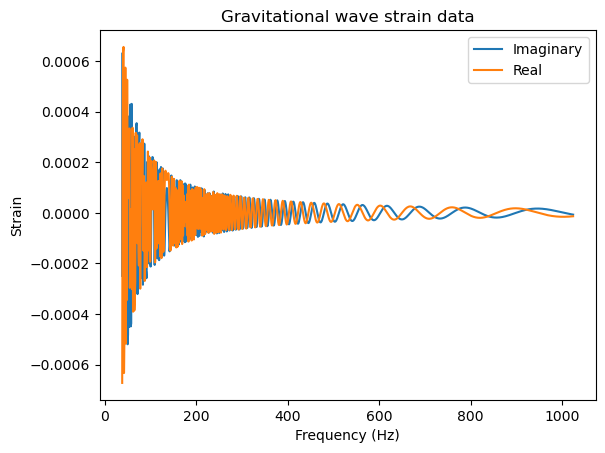

In [3]:
plt.plot(model.frequency, model.strain(injection, model.frequency).imag, label='Imaginary')
plt.plot(model.frequency, model.strain(injection, model.frequency).real, label='Real')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')
plt.legend()
plt.title('Gravitational wave strain data')

# Run some quick checks on the derivatives

In [4]:
x = model.injection + np.random.uniform(low=0, high=0.0001, size=model.DoF)

print('Make sure autodiff and analytically calculated gradient of strain agree')
print(jax.jacfwd(model.strain)(x,10))
print(model.gradient_strain(x, 10))

# -------------------------------------------------------------------------------

print('Make sure derivative of potentials agree')
print(jax.jacfwd(model.potential_single)(x))
print(model.gradient_potential_single(x))

# -------------------------------------------------------------------------------

print('Make sure Jacobian calculation is stable')
print(jax.jacrev(model.potential_single)(x))
print(jax.jacfwd(model.potential_single)(x))

Make sure autodiff and analytically calculated gradient of strain agree
[ 5.42640814e-02+2.07308840e-01j -8.63639679e-04-3.29942266e-03j
 -4.71977464e+01-1.80312829e+02j -1.83607778e-01-7.01449551e-01j
 -6.59087244e-02+1.72519241e-02j  7.30601525e-02+2.79116776e-01j
  4.31440391e-01+1.64826170e+00j]
[ 5.42640814e-02+2.07308840e-01j -8.63639679e-04-3.29942266e-03j
 -4.71977464e+01-1.80312829e+02j -1.83607778e-01-7.01449551e-01j
 -6.59087244e-02+1.72519241e-02j  7.30601525e-02+2.79116776e-01j
  4.31440391e-01+1.64826170e+00j]
Make sure derivative of potentials agree
[-9.63000311e+03  2.64295101e+01  9.11886290e+04 -1.37954340e+03
  5.30067438e+01 -6.90395273e+02 -4.05487090e+03]
[-9.63000311e+03  2.64295101e+01  9.11886290e+04 -1.37954340e+03
  5.30067438e+01 -6.90395273e+02 -4.05487090e+03]
Make sure Jacobian calculation is stable
[-9.63000311e+03  2.64295101e+01  9.11886290e+04 -1.37954340e+03
  5.30067438e+01 -6.90395273e+02 -4.05487090e+03]
[-9.63000311e+03  2.64295101e+01  9.1188629

In [ ]:
# Calculate cross sections of PDF

def getCrossSection(index1, index2, func, injection, lower_bound, upper_bound, index_label, ngrid=200):
    DoF = len(injection)
    x = np.linspace(lower_bound[index1], upper_bound[index1], ngrid)
    y = np.linspace(lower_bound[index2], upper_bound[index2], ngrid)
    X, Y = np.meshgrid(x, y)
    particle_grid = np.zeros((ngrid ** 2, DoF))
    parameter_mesh = np.vstack((np.ndarray.flatten(X), np.ndarray.flatten(Y))).T

    particle_grid[:, index1] = parameter_mesh[:, 0]
    particle_grid[:, index2] = parameter_mesh[:, 1]
    for i in range(DoF): # Fix all other parameters
        if i != index1 and i != index2:
            particle_grid[:, i] = np.ones(ngrid ** 2) * injection[i]

    Z = func(particle_grid).reshape(ngrid,ngrid)

    fig, ax = plt.subplots(figsize = (5, 5))
    cp = ax.contourf(X, Y, Z)
    plt.colorbar(cp)
    ax.set_xlabel(index_label[index1])
    ax.set_ylabel(index_label[index2])
    ax.set_title('Cross section of PDF')
    filename = str(index1) + str(index2) + '.png'
    path = os.path.join('marginals', filename)
    # fig.savefig(path)

posterior = lambda X: np.exp(-1 * model.getMinusLogPosterior_ensemble(X))

neg_potential = lambda X: -1 * model.getMinusLogPosterior_ensemble(X)

for i in range(5):
    for j in range(i+1, 5):
        # print('Getting cross section for %s' % pair)
        getCrossSection(i, j, neg_potential, injection, model.lower_bound, model.upper_bound, model.index_label)

# Try sampling from model with `jaxns`

In [ ]:
# from jax.config import config

# config.update("jax_enable_x64", True)

# import pylab as plt
import tensorflow_probability.substrates.jax as tfp
# from jax import random, numpy as jnp
from jax import random
# from jax import vmap

# import jaxns
from jaxns import ExactNestedSampler
from jaxns import Model
from jaxns import PriorModelGen, Prior
from jaxns import TerminationCondition

tfpd = tfp.distributions

In [ ]:
def prior_model() -> PriorModelGen:
    x = yield Prior(tfpd.Uniform(low=model.lower_bound, high=model.upper_bound), name='x')
    return x

jaxns_model = Model(prior_model=prior_model, log_likelihood=lambda x: -1 * model.potential_single(x))

exact_ns = ExactNestedSampler(model=jaxns_model, num_live_points=1000, num_parallel_samplers=1, max_samples=1e5)

termination_reason, state = exact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-5))

# termination_reason, state = exact_ns(random.PRNGKey(42), term_cond=TerminationCondition(max_samples=1e5))
# termination_reason, state = exact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))

results = exact_ns.to_results(state, termination_reason)

In [ ]:
exact_ns.summary(results)
exact_ns.plot_diagnostics(results)
exact_ns.plot_cornerplot(results)

In [ ]:
import jax.lax as lax
from jax.experimental import host_callback

def progress_bar_scan(num_samples, message=None):
    "Progress bar for a JAX scan"
    if message is None:
            message = f"Running for {num_samples:,} iterations"
    tqdm_bars = {}

    if num_samples > 20:
        print_rate = int(num_samples / 20)
    else:
        print_rate = 1 # if you run the sampler for less than 20 iterations
    remainder = num_samples % print_rate

    def _define_tqdm(arg, transform):
        tqdm_bars[0] = tqdm(range(num_samples))
        tqdm_bars[0].set_description(message, refresh=False)

    def _update_tqdm(arg, transform):
        tqdm_bars[0].update(arg)

    def _update_progress_bar(iter_num):
        "Updates tqdm progress bar of a JAX scan or loop"
        _ = lax.cond(
            iter_num == 0,
            lambda _: host_callback.id_tap(_define_tqdm, None, result=iter_num),
            lambda _: iter_num,
            operand=None,
        )

        _ = lax.cond(
            # update tqdm every multiple of `print_rate` except at the end
            (iter_num % print_rate == 0) & (iter_num != num_samples-remainder),
            lambda _: host_callback.id_tap(_update_tqdm, print_rate, result=iter_num),
            lambda _: iter_num,
            operand=None,
        )

        _ = lax.cond(
            # update tqdm by `remainder`
            iter_num == num_samples-remainder,
            lambda _: host_callback.id_tap(_update_tqdm, remainder, result=iter_num),
            lambda _: iter_num,
            operand=None,
        )

    def _close_tqdm(arg, transform):
        tqdm_bars[0].close()

    def close_tqdm(result, iter_num):
        return lax.cond(
            iter_num == num_samples-1,
            lambda _: host_callback.id_tap(_close_tqdm, None, result=result),
            lambda _: result,
            operand=None,
        )


    def _progress_bar_scan(func):
        """Decorator that adds a progress bar to `body_fun` used in `lax.scan`.
        Note that `body_fun` must either be looping over `np.arange(num_samples)`,
        or be looping over a tuple who's first element is `np.arange(num_samples)`
        This means that `iter_num` is the current iteration number
        """

        def wrapper_progress_bar(carry, x):
            if type(x) is tuple:
                iter_num, *_ = x
            else:
                iter_num = x   
            _update_progress_bar(iter_num)
            result = func(carry, x)
            return close_tqdm(result, iter_num)

        return wrapper_progress_bar

    return _progress_bar_scan

In [ ]:
from models.JAXHRD import hybrid_rosenbrock

n2 = 3
n1 = 4
DoF = n2 * (n1 - 1) + 1
B = np.zeros(DoF)
B[0] = 30
B[1:] = 20
mu=1
model = hybrid_rosenbrock(n2, n1, mu, B, seed=35)
# bounded_iid_samples = np.load('rosenbrock_iid_bounded_samples.npy')
# Load iid samples
# try:
#     bounded_iid_samples = np.load('rosenbrock_iid_bounded_samples.npy')
# except:
#     np.random.seed(2)
iid_samples = model.newDrawFromPosterior(50000000)
truth_table = ((iid_samples > model.lower_bound) & (iid_samples < model.upper_bound))
idx = np.where(np.all(truth_table, axis=1))[0]
print('%i samples obtained from rejection sampling' % idx.shape[0])
bounded_iid_samples = iid_samples[idx]

# Try getting it working with full jax langevin

In [ ]:
from functools import partial
# import jax
# config.update("jax_enable_x64", True)
# config.update("jax_debug_nans", True)
# Use potential!
from src.reparameterization import reparameterization, sigma, logistic_CDF

def ula_kernel(key, param, log_post, grad_log_post, dt):
    key, subkey = jax.random.split(key)
    paramGrad = grad_log_post(param)

    V_X = log_post(param)

    # Transform to unbounded domain
    eta, V_Y, gmlpt_Y = reparameterization(param, V_X, paramGrad, model.lower_bound, model.upper_bound)

    # Perform update in unbounded domain
    eta += -gmlpt_Y * dt + jnp.sqrt(2 * dt) * jnp.random.normal(key=subkey, size=(param.shape))

    # Convert samples back to bounded domain 
    param = sigma(logistic_CDF(eta), model.lower_bound, model.upper_bound)

    # param = param - dt*paramGrad + jnp.sqrt(2*dt)*jax.random.normal(key=subkey, shape=(param.shape))
    
    return key, param

@partial(jax.jit, static_argnums=(1,2,3))
def ula_sampler_full_jax_jit(key, log_post, grad_log_post, n_iter, dt, x_0):

    # @progress_bar_scan(n_iter)
    def ula_step(carry, x):
        key, param = carry
        key, param = ula_kernel(key, param, log_post, grad_log_post, dt)
        return (key, param), param

    carry = (key, x_0)
    _, samples = jax.lax.scan(ula_step, carry, None, n_iter)
    return samples

key = jax.random.PRNGKey(0)




In [ ]:
n_iter = 10000
n_particles = 100
eps = 1e-4
X0 = model._newDrawFromPrior(n_particles)
sam = ula_sampler_full_jax_jit(key, jax.vmap(model.getMinusLogPosterior), jax.vmap(model.getGradientMinusLogPosterior), n_iter, eps, X0)

In [ ]:
reshaped_matrix = sam.reshape((n_iter * n_particles, model.DoF))
corner.corner(reshaped_matrix[-1000:])

In [ ]:
sam[3]